In [21]:
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py
import copy

# Project modules
from lib.Stokes import Stokes
from functions.plot_data import plot_data

In [22]:
# Open datafile
datafile = 'data/AR_12665_133153_0.h5'
print("Reading data file", datafile)
data = h5py.File(datafile, 'r')
print("Opened data file", data.file)

# Print data parameters
print("List of keys in file:", list(data.keys()))
key = list(data.keys())[0]
print("    Number of strokes parameters:   ", data[key].shape[0])
print("    Size of X axis:                 ", data[key].shape[1])
print("    Size of Y axis:                 ", data[key].shape[2])
print("    Number of measured wavelengths: ", data[key].shape[3])

Reading data file data/AR_12665_133153_0.h5
Opened data file <HDF5 file "AR_12665_133153_0.h5" (mode r)>
List of keys in file: ['stokes']
    Number of strokes parameters:    4
    Size of X axis:                  605
    Size of Y axis:                  768
    Number of measured wavelengths:  112


In [23]:
# Extract each Stokes parameter into dictionary
i = 0
I = Stokes('I', data['stokes'][0])
Q = Stokes('Q', data['stokes'][1])
U = Stokes('U', data['stokes'][2])
V = Stokes('V', data['stokes'][3])
stokes_list = {'I': I, 'Q': Q, 'U': U, 'V': V}
for stokes in stokes_list:
    print(stokes, 'shape:', stokes_list[stokes].data.shape)
    i = i + 1

I shape: (768, 605, 112)
Q shape: (768, 605, 112)
U shape: (768, 605, 112)
V shape: (768, 605, 112)


In [24]:
# # Plot all figures to see where there is signal
# # Commented because it takes a few minutes to run
# for param in stokes_list:
#     fig = stokes_list[param].plot_all_frames()
#     fig.savefig("generated/" + str(param) + "_all_frames.png", dpi=150)
#     print("Saved figure to file", "generated/" + str(param) + "_all_frames.png")

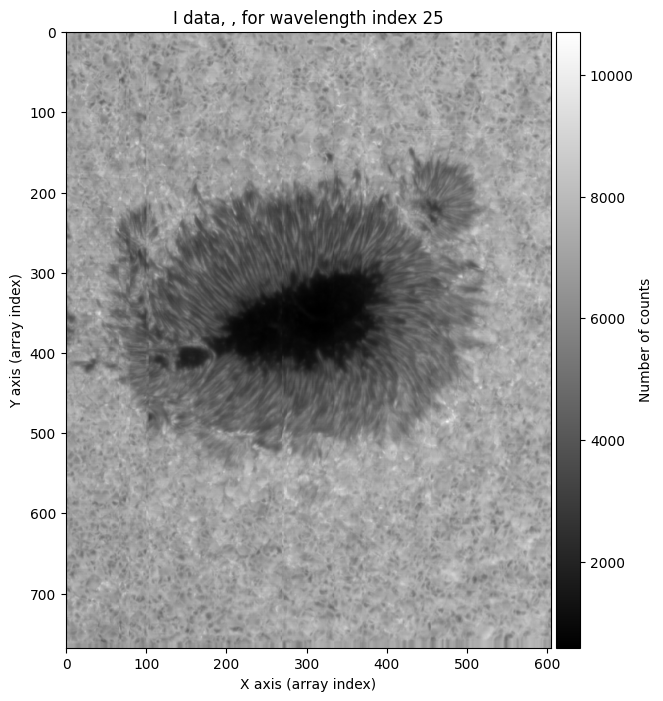

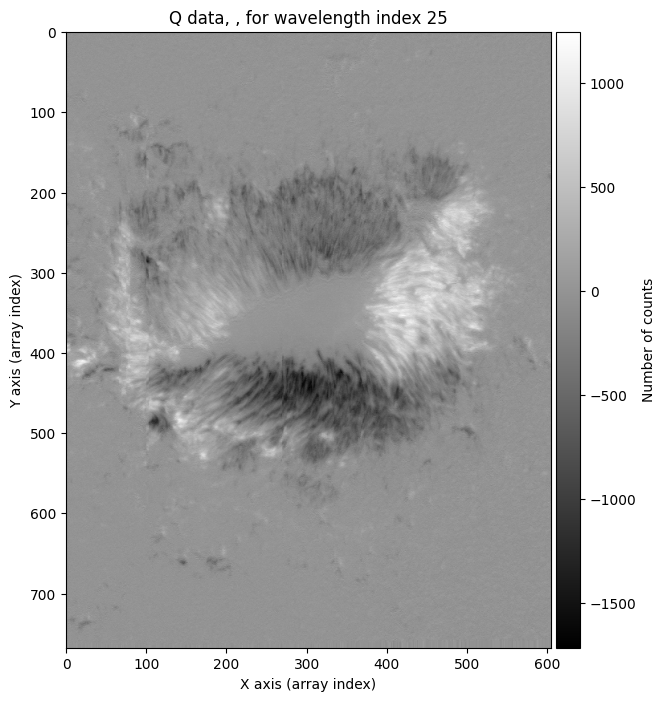

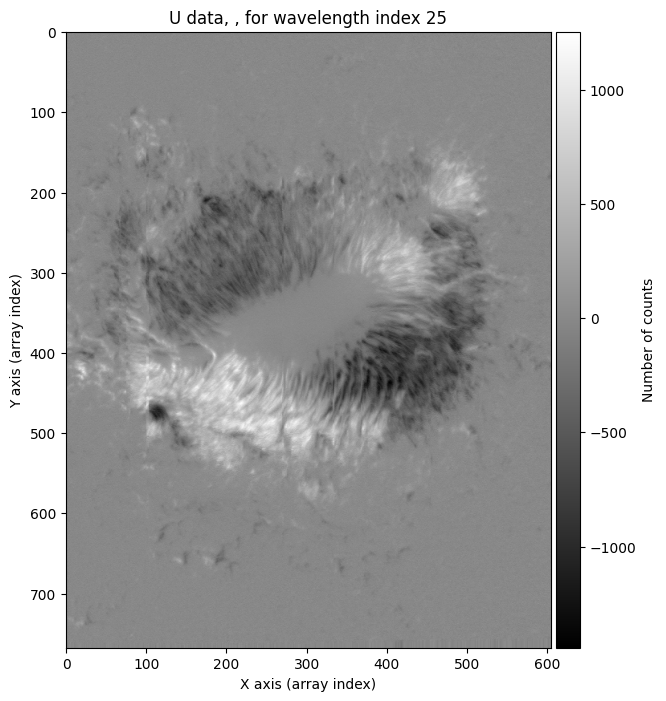

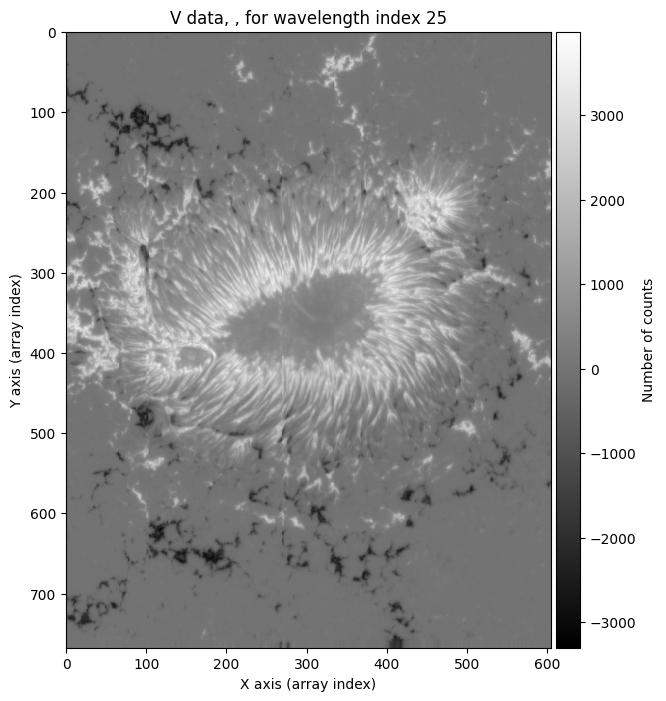

In [25]:
# Plot one image for each parameter where we are sure to have signal (after studying the plots at all wavelengths)
index_frame = 25
for param in stokes_list:
    stokes_list[param].plot_frame(index_frame)

In [26]:
# Calculate total polarization

# Apply formula to each wavelength
mp = np.empty(I.data.shape)
for i in range(112):
    mp[:,:,i] = np.sqrt(Q.data[:,:,i]**2 + U.data[:,:,i]**2 + V.data[:,:,i]**2) / I.data[:,:,i]

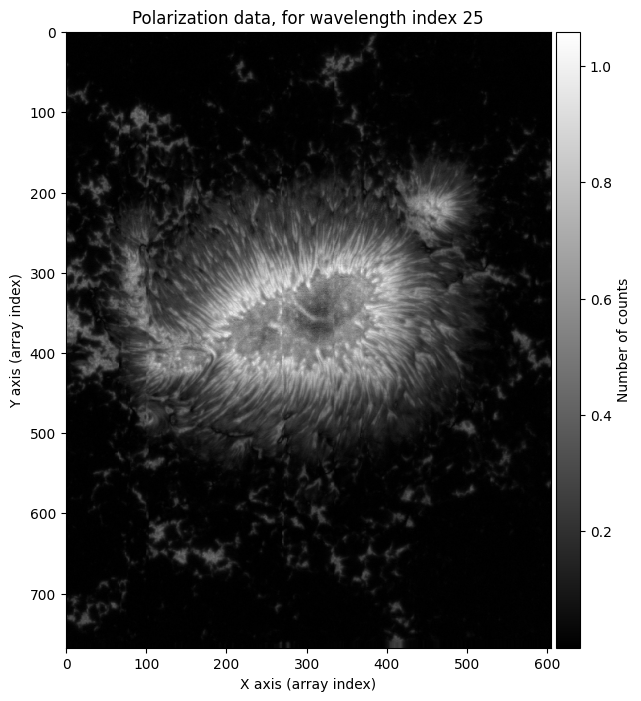

(<Figure size 800x800 with 2 Axes>,
 <Axes: title={'center': 'Polarization data, for wavelength index 25'}, xlabel='X axis (array index)', ylabel='Y axis (array index)'>)

In [27]:
# Plot one frame of data
plot_data(mp[:,:,index_frame], "Polarization data, for wavelength index " + str(index_frame))

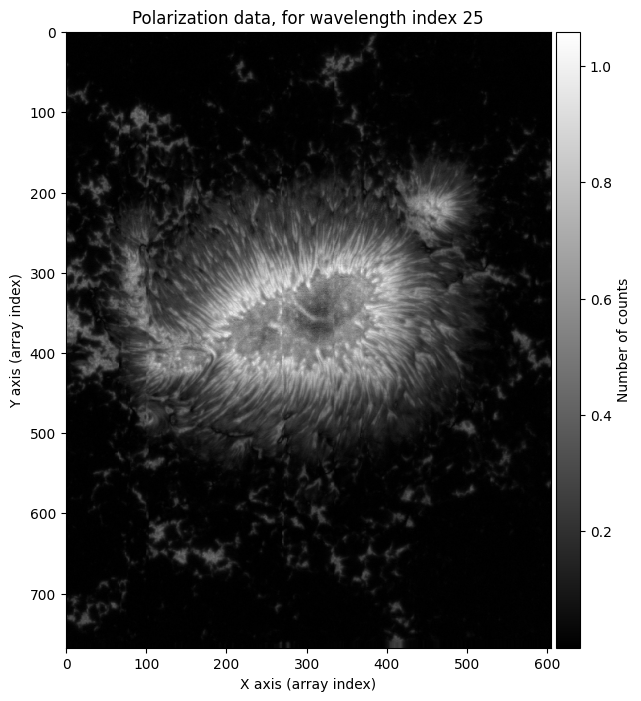

In [28]:
# Select region of quiet sun for calibration intensity calculation
xmin = 480
xmax = 605
ymin = 0
ymax = 180
xwidth = xmax - xmin
ywidth = ymax - ymin
# We want to select a region with little total polarization, since this implies a low magnetic field -> quiet sun

# Plot polarization
fig, ax = plot_data(mp[:,:,index_frame], "Polarization data, for wavelength index " + str(index_frame))

# Create a rectangle patch
rect = patches.Rectangle((xmin, ymin), xwidth, ywidth, linewidth=10, edgecolor='r', facecolor='none') # TODO: this patch stopped working :/

# Add the patch to the Axes
ax.add_patch(rect)

Calculating quiet sun profile for object  I
Calculating quiet sun profile for object  Q
Calculating quiet sun profile for object  U
Calculating quiet sun profile for object  V


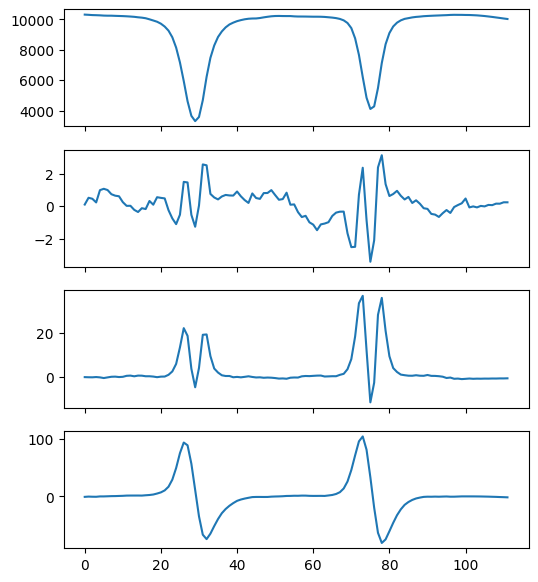

In [29]:
# Calulate mean value of quiet sun area for each wavelength
# and plot the profile
fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(6, 7), sharex='col',)
i = 0
for param in stokes_list:
    stokes_list[param].mean_quiet_region(xmin, xmax, ymin, ymax)

    img = ax[i].plot(stokes_list[param].mean_quiet)
    i +=1

In [30]:
# Open calibration data
calibfile = 'data/fts_calibration.npz'
print("Reading calibration data file", calibfile)
calibdata = np.load(calibfile)
print("Opened calibration data file")

# Print data parameters
print("List of keys in file:", list(calibdata.files))
key = list(calibdata.files)
print("With shape:")
print("    Wavelength daya (x):           ", calibdata[key[0]].shape)
print("    Intensity (y):                 ", calibdata[key[0]].shape)
print("    Continuum (c):                 ", calibdata[key[0]].shape)

Reading calibration data file data/fts_calibration.npz
Opened calibration data file
List of keys in file: ['x', 'y', 'c']
With shape:
    Wavelength daya (x):            (554,)
    Intensity (y):                  (554,)
    Continuum (c):                  (554,)


Peaks in I data:  [29 53 60 75]
Centroix pixels on spectrum:  [29.04490697 74.9093139 ]


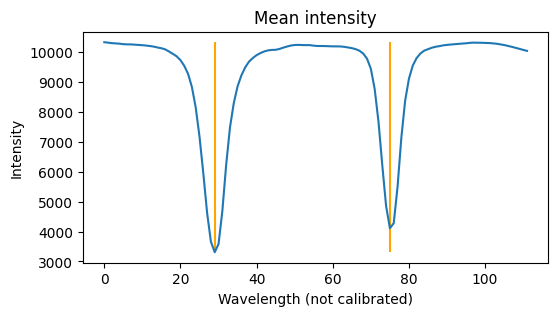

In [31]:
# Get spectral lines from data spectrum
spectrum = copy.copy(I.mean_quiet)
peaks, _ = find_peaks(-spectrum) 
print("Peaks in I data: ", peaks)
# TODO: figure out why it's getting four peaks
peaks = [29, 75]

# Example from here: https://eikonaloptics.com/blogs/tutorials/spectrometer-wavelength-calibration-practical-implementation?srsltid=AfmBOoqBsKn0cOmwJ4wTow4yGllnfrRJAqNRn0FOSJ3sFu7leDetbL1D
# Find centroid of spectral lines
npix = 4
centroid_pix = np.array([])
for p in peaks:
  pix = np.arange(p-npix, p+npix+1)
  centroid_pix = np.append(centroid_pix,
                 np.sum(spectrum[p-npix: p+npix+1] * pix) / np.sum(spectrum[p-npix: p+npix+1]))
  
print("Centroix pixels on spectrum: ", centroid_pix)

# Plot on spectrum
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))
ax.set_xlabel('Wavelength (not calibrated)')
ax.set_ylabel('Intensity')
ax.set_title("Mean intensity")
ax.vlines(centroid_pix, spectrum.min(), spectrum.max(), colors='orange')
img = ax.plot(spectrum)

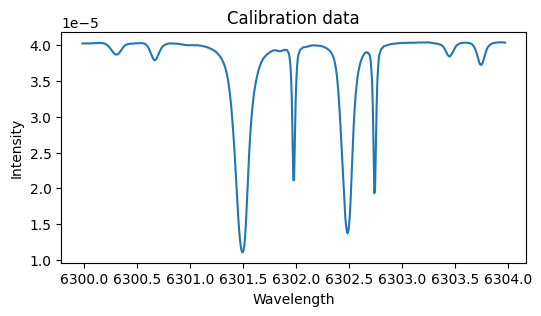

In [32]:
# Plot calibration data
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))
ax.set_xlabel('Wavelength')
ax.set_ylabel('Intensity')
ax.set_title("Calibration data")

img = ax.plot(calibdata['x'], calibdata['y'])

Peaks in calibration data:  [  2   4   8  12  17  21  27  45  65  72  76  94 119 134 139 144 148 210
 257 259 266 277 299 302 306 309 347 372 382 408 418 423 427 431 435 443
 447 450 460 480 496 501 521 546]
Wavelengths of Fe I peaks:  [np.float32(6301.5015), np.float32(6302.4893)]


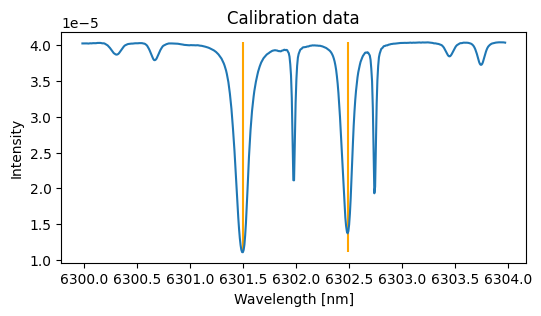

In [33]:
# Get spectral lines from calibration spectrum
calib_spectrum = calibdata['y']
calib_peaks, _ = find_peaks(-calib_spectrum) # find absortion lines
print("Peaks in calibration data: ", calib_peaks)
# Keep peaks which match the Fe I lines (manually)
calib_peaks_clean = [210, 347]

# Get wavelength values of Fe I peaks
calib_wavelengths = [calibdata['x'][210], calibdata['x'][347]]
print("Wavelengths of Fe I peaks: ", calib_wavelengths)

# Plot calibration data
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Intensity')
ax.set_title("Calibration data")
ax.vlines(calib_wavelengths, calib_spectrum.min(), calib_spectrum.max(), colors='orange')
img = ax.plot(calibdata['x'], calibdata['y'])

Polyfit coefficients:  [2.15351158e-02 6.30087608e+03]


Text(0.5, 1.0, 'Polyfit results')

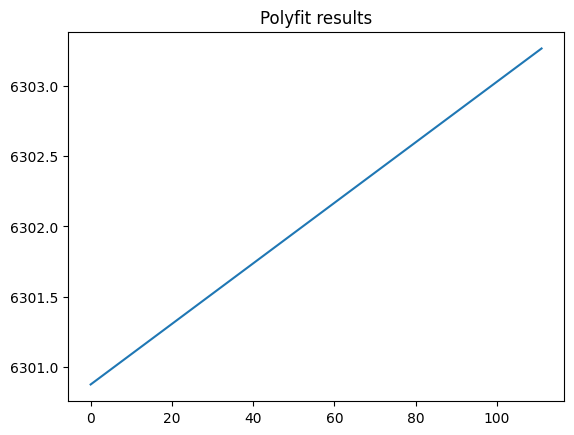

In [34]:
# Calculate polynomial which fits the spectra to the calibration wavelengths
poly_degree = 1
coeffs_wave_cal = np.polyfit(centroid_pix, calib_wavelengths, deg=poly_degree, w=[20,2])
print("Polyfit coefficients: ", coeffs_wave_cal)

plt.plot(np.polyval(coeffs_wave_cal, np.arange(112)))
plt.title("Polyfit results")

Text(0.5, 0, 'Calibrated wavelength [nm]')

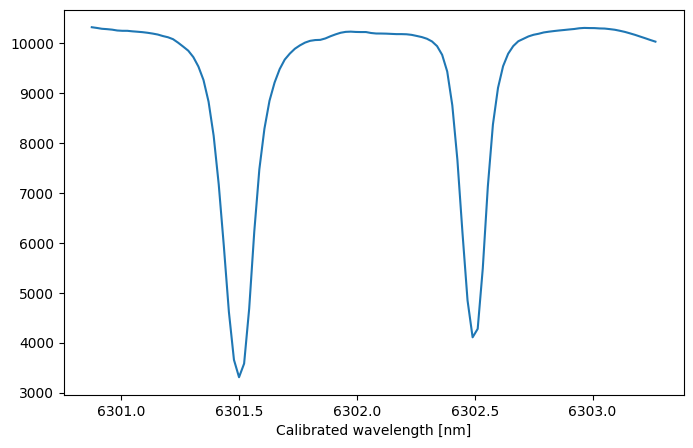

In [35]:
# Adjust spectrum with the calculated polynomial
pix_val = np.arange(len(spectrum))
calibrated_axis = np.polyval(coeffs_wave_cal, pix_val)

# Plot the spectrum with the newly calibrated wavelengths. 
plt.figure(figsize=(8,5))
plt.plot(calibrated_axis, spectrum)
plt.xlabel('Calibrated wavelength [nm]')

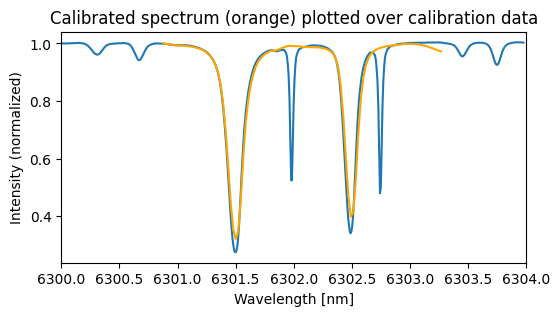

In [36]:
# Normalize spectrum and calibration data, mean of first value
spectrum_n = spectrum / spectrum[0]
calibdata_n = calibdata['y'] / calibdata['y'][0] # this is wrong but useful for visual confirmation

# Compare calibrated spectum to calibration data
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Intensity (normalized)')
ax.set_title("Calibrated spectrum (orange) plotted over calibration data")
ax.set_xlim([6300, 6304])
img = ax.plot(calibdata['x'], calibdata_n)
img = ax.plot(calibrated_axis, spectrum_n, color='orange')

In [37]:
# Add wavelength axis to objects
for param in stokes_list:
    stokes_list[param].add_wavelength(calibrated_axis)

Saving wavelength calibration to I object
Saving wavelength calibration to Q object
Saving wavelength calibration to U object
Saving wavelength calibration to V object


In [38]:
# Normalize all datacubes by didiving by the wavelength
for param in stokes_list:
    stokes_list[param].normalize()

Normalizing data for I and saving to object
Normalizing data for Q and saving to object
Normalizing data for U and saving to object
Normalizing data for V and saving to object


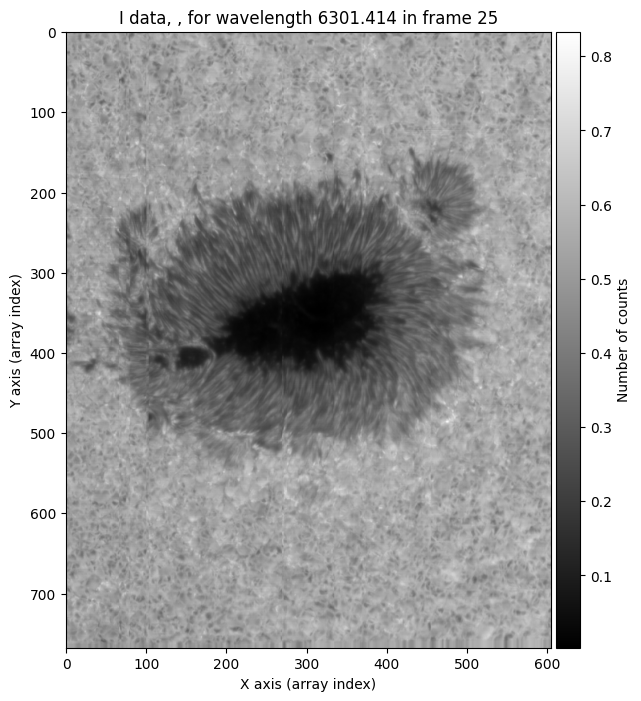

Saved figure to file generated/I_frame_25.png


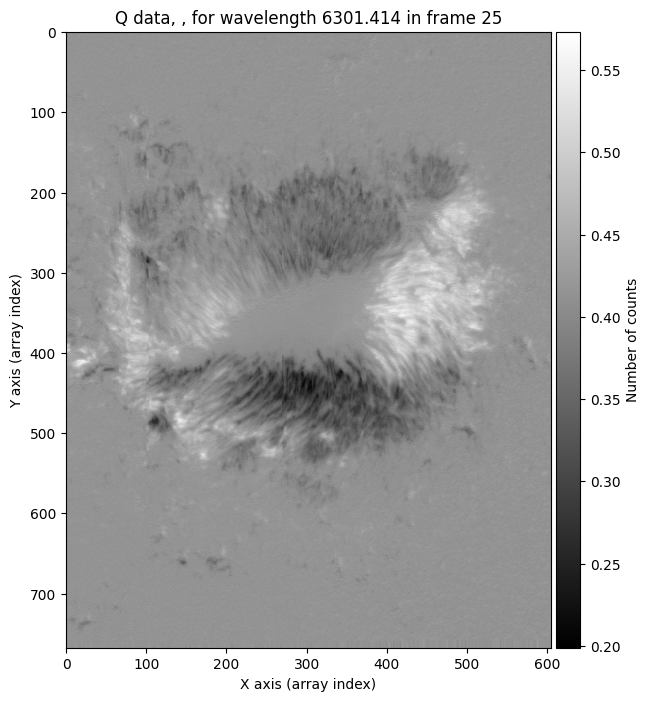

Saved figure to file generated/Q_frame_25.png


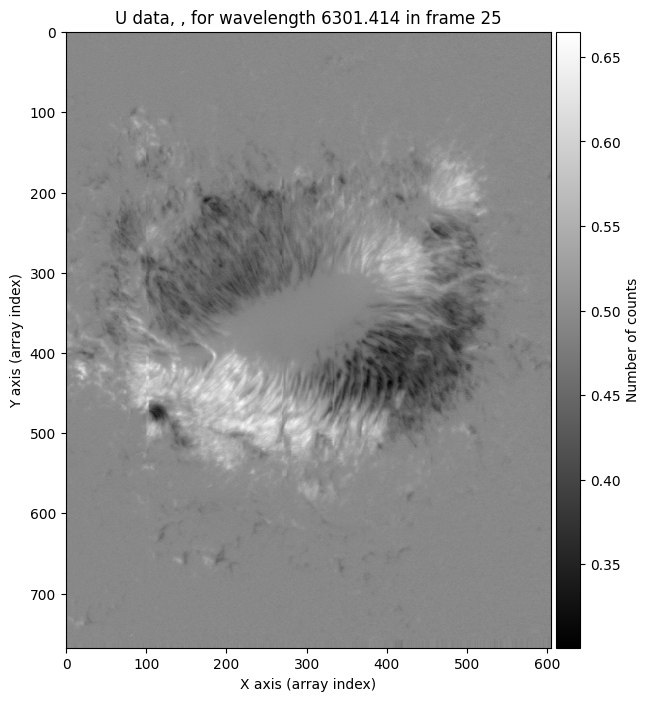

Saved figure to file generated/U_frame_25.png


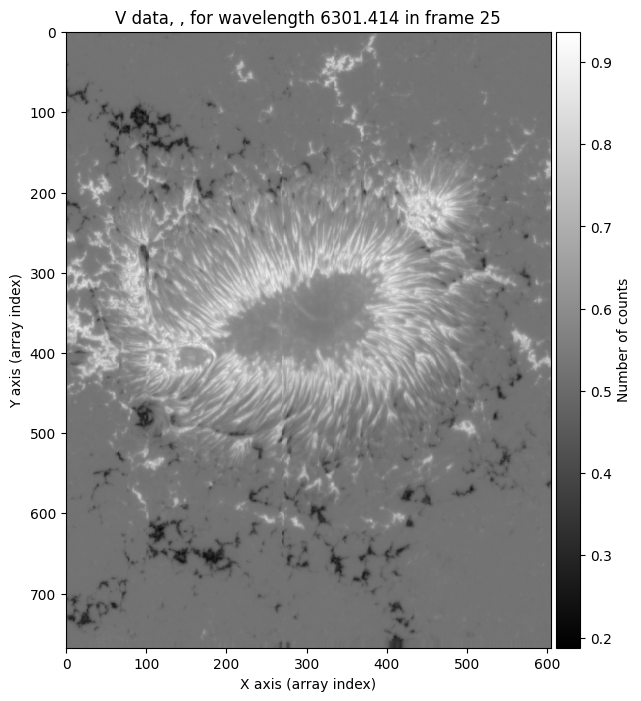

Saved figure to file generated/V_frame_25.png


In [39]:
# Plot normalized data, all Stokes parameters for the spectral line, where wavelength = 6301.5 nm
wavelength = 6301.5
for param in stokes_list:
    fig = stokes_list[param].plot_frame_n(25)
    fig.savefig("generated/" + str(param) + "_frame_25.png", dpi=200)
    print("Saved figure to file", "generated/" + str(param) + "_frame_25.png")

In [ ]:
# Calculate polarizations, plot images

from lib.Derived import Derived

# Initializing derived parameter object
nova = Derived(stokes_list)

# Calculate total polarization
print("Calculaing total polarization")
nova.total_polarization()
fig, _ = nova.plot_total_polarization()
fig.savefig("generated/" + "total_polarization.png", dpi=200)
print("Saved figure to file", "generated/total_polarization.png")


# Calculate linear polarization
print("Calculaing linear polarization")
nova.linear_polarization()
fig, _ = nova.plot_linear_polarization()
fig.savefig("generated/" + "linear_polarization.png", dpi=200)
print("Saved figure to file", "generated/linear_polarization.png")

# Calculate circular polarization
print("Calculaing circular polarization")
nova.circular_polarization()
fig, _ = nova.plot_circular_polarization()
fig.savefig("generated/" + "circular_polarization.png", dpi=200)
print("Saved figure to file", "generated/circular_polarization.png")

Calculaing total polarization


AttributeError: 'Stokes' object has no attribute 'data_normalized'

: 